In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from shogun import *
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [315]:
query = \
"""
set search_path to mimiciii;

-- Staging table #1: CHARTEVENTS
with ce_stg as
(
  select ie.subject_id, ie.hadm_id, ie.icustay_id, EXTRACT('epoch' from chart.charttime - ie.intime) / 60.0 / 60.0 as timestamp_hours
  , case
      when itemid in (211,220045) and chart.valuenum > 0 and chart.valuenum < 300 then 1 -- HeartRate
      else null end as vitalid
  , case
      when chart.itemid = any (ARRAY[223761, 678]) then (chart.valuenum - 32::double precision) / 1.8::double precision
      else chart.valuenum end as valuenum

  from icustays ie
  left join chartevents chart
    on ie.subject_id = chart.subject_id and ie.hadm_id = chart.hadm_id and ie.icustay_id = chart.icustay_id
    and chart.charttime >= ie.intime and chart.charttime <= (ie.intime + '1 day'::interval day)
    and chart.error is distinct from 1
    where chart.itemid = any
    (array[
    -- HEART RATE
    211, --"Heart Rate"
    220045 --"Heart Rate"
    ])
)
-- Aggregate table #1: CHARTEVENTS
, ce as
(
  SELECT ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id, ce_stg.timestamp_hours
  , case when VitalID = 1 then valuenum else null end as HeartRate
  FROM ce_stg
  group by ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id, ce_stg.vitalid, ce_stg.valuenum, ce_stg.timestamp_hours
  order by ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '6 hour' THEN 1 
    ELSE 0 END as hospital6hours_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '12 hour' THEN 1 
    ELSE 0 END as hospital12hours_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '18 hour' THEN 1 
    ELSE 0 END as hospital18hours_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' day THEN 1 
    ELSE 0 END as hospital1day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '7' day THEN 1 
    ELSE 0 END as hospital1week_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital1month_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #3: Services
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)


SELECT ie.icustay_id, ie.subject_id, ie.hadm_id
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, HeartRate, ce.timestamp_hours

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
-- , co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, co.hospital1month_expire_flag, co.hospital1week_expire_flag
, co.hospital6hours_expire_flag, co.hospital12hours_expire_flag, co.hospital18hours_expire_flag 
, co.hospital1day_expire_flag

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM icustays ie
inner join admissions adm
  on ie.hadm_id = adm.hadm_id
inner join patients pat
  on ie.subject_id = pat.subject_id
left join ce
  on ie.icustay_id = ce.icustay_id
left join co
  on ie.icustay_id = co.icustay_id
left join excl
  on ie.icustay_id = excl.icustay_id

"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,age_icu_in,first_careunit,gender,admission_type,heartrate,timestamp_hours,hospital_expire_flag,...,hospital1month_expire_flag,hospital1week_expire_flag,hospital6hours_expire_flag,hospital12hours_expire_flag,hospital18hours_expire_flag,hospital1day_expire_flag,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,235175,764,186125,0.000063,NICU,F,NEWBORN,144.0,0.701111,0,...,0,0,0,0,0,0,1,1,0,0
1,257671,808,197130,55.391621,SICU,F,EMERGENCY,146.0,1.684167,0,...,0,0,0,0,0,0,0,0,1,0
2,257671,808,197130,55.391621,SICU,F,EMERGENCY,145.0,9.684167,0,...,0,0,0,0,0,0,0,0,1,0
3,257671,808,197130,55.391621,SICU,F,EMERGENCY,145.0,8.684167,0,...,0,0,0,0,0,0,0,0,1,0
4,257671,808,197130,55.391621,SICU,F,EMERGENCY,144.0,10.684167,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
query_output = pd.read_csv('./timeseries-heartrate.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital1month_expire_flag', 
                   'hospital1week_expire_flag', 'hospital1day_expire_flag',
                   'hospital6hours_expire_flag', 'hospital12hours_expire_flag',
                   'hospital18hours_expire_flag']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type']

feature_names = [
            # Vital signs
            'heartrate', 'timestamp_hours', 
                 
            ]

query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names)]

features.head()

,admission_type,age_icu_in,first_careunit,gender,heartrate,subject_id,timestamp_hours
0,1,37.446714,2,0,101.0,891,0.0475
1,1,37.446714,2,0,100.0,891,7.2975
2,1,37.446714,2,0,95.0,891,18.2975
3,1,37.446714,2,0,86.0,891,13.7975
4,1,37.446714,2,0,86.0,891,0.2975


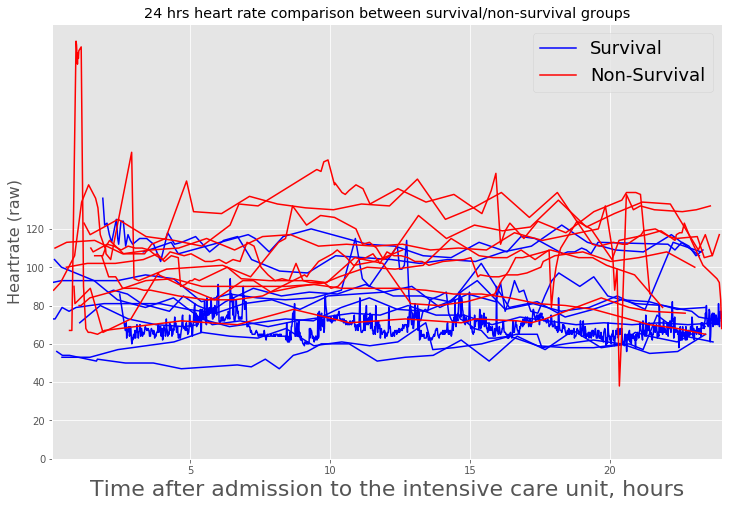

In [188]:
survival = query_output.loc[query_output.hospital1day_expire_flag == 0]
non_survival = query_output.loc[query_output.hospital1day_expire_flag != 0]

surv_rows = np.random.choice(survival.subject_id.values, 10)
non_surv_rows = np.random.choice(non_survival.subject_id.values, 10)

survival = survival.loc[survival.subject_id.isin(surv_rows)].sort_values('timestamp_hours')
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)].sort_values('timestamp_hours')

fig, ax = plt.subplots(figsize=(12, 8))

for title, group in survival.groupby('subject_id'):
    group.plot(x='timestamp_hours', y='heartrate', label='survival', ax=ax, color='blue')

for title, group in non_survival.groupby('subject_id'):
    group.plot(x='timestamp_hours', y='heartrate', label='non-survival', ax=ax, color='red')    

legend = plt.legend(['Survival', 'Non-Survival'], fontsize=18)
legend.get_lines()[1].set_color('red')
plt.xlabel('Time after admission to the intensive care unit, hours', fontsize=22)
plt.ylabel('Heartrate (raw)', fontsize=16)
plt.yticks(np.arange(0, 140, 20))
plt.title('24 hrs heart rate comparison between survival/non-survival groups')
plt.show()

In [5]:
lagged_df = pd.DataFrame()
for i in range(6, 24, 6):
    X_mean = features.loc[features.timestamp_hours < i]['heartrate'].groupby(features['subject_id']).mean()
    X_median = features.loc[features.timestamp_hours < i]['heartrate'].groupby(features['subject_id']).median()
    X_min = features.loc[features.timestamp_hours < i]['heartrate'].groupby(features['subject_id']).min()
    X_max = features.loc[features.timestamp_hours < i]['heartrate'].groupby(features['subject_id']).max()
    
    lagged_df['min_hr_%dhours' % i] = X_min
    lagged_df['max_hr_%dhours' % i] = X_max
    lagged_df['mean_hr_%dhours' % i] = X_mean
    lagged_df['median_hr_%dhours' % i] = X_median    
    lagged_df['mortality_%dhours' % i] = outcomes.loc[X_mean.index]['hospital%dhours_expire_flag' % i]

X_min = features.loc[features.timestamp_hours < 24]['heartrate'].groupby(features['subject_id']).min()
X_max = features.loc[features.timestamp_hours < 24]['heartrate'].groupby(features['subject_id']).max()
X_mean = features.loc[features.timestamp_hours < 24]['heartrate'].groupby(features['subject_id']).mean()   
X_median = features.loc[features.timestamp_hours < 24]['heartrate'].groupby(features['subject_id']).median()    

lagged_df['min_hr_1day'] = X_min
lagged_df['max_hr_1day'] = X_max
lagged_df['mean_hr_1day'] = X_mean
lagged_df['median_hr_1day'] = X_median

lagged_df['mortality_1day'] = outcomes.loc[X_mean.index].hospital1day_expire_flag
lagged_df.head()

,min_hr_6hours,max_hr_6hours,mean_hr_6hours,median_hr_6hours,mortality_6hours,min_hr_12hours,max_hr_12hours,mean_hr_12hours,median_hr_12hours,mortality_12hours,min_hr_18hours,max_hr_18hours,mean_hr_18hours,median_hr_18hours,mortality_18hours,min_hr_1day,max_hr_1day,mean_hr_1day,median_hr_1day,mortality_1day
subject_id,,,,,,,,,,,,,,,,,,,,
3,121.0,168.0,141.117647,143.0,0,97.0,168.0,131.500000,134.5,0,82.0,168.0,120.968750,122.5,0,75.0,168.0,111.785714,105.5,0
4,74.0,111.0,89.166667,85.0,0,74.0,111.0,87.250000,85.5,0,74.0,111.0,87.833333,88.0,0,74.0,111.0,89.217391,89.0,0
6,79.0,84.0,81.666667,82.0,0,76.0,86.0,81.750000,82.5,0,76.0,98.0,82.842105,83.0,0,76.0,100.0,84.160000,83.0,0
9,82.0,95.0,86.230769,85.0,0,82.0,103.0,89.035714,88.0,0,82.0,111.0,91.176471,90.0,0,82.0,111.0,92.500000,91.5,0
11,86.0,97.0,91.666667,91.5,0,78.0,97.0,88.500000,89.0,0,74.0,97.0,86.055556,87.5,0,70.0,101.0,84.958333,86.0,0


In [7]:
# random forest parameters
n_trees = 100

k = 10
features[demographics].drop_duplicates().set_index('subject_id')    

metric = ROCEvaluation()

results = {}
total_results = {}

predictions = ['6hours', '12hours', '18hours', '1day']
for pred in predictions:
    print(pred)
    heartrate = lagged_df.loc[:, lagged_df.columns.str.contains('hr_' + pred)]
    feats = features[demographics].drop_duplicates().set_index('subject_id').loc[heartrate.index]
    X = pd.concat([heartrate, feats], axis=1).reset_index(drop=True)
    y = lagged_df.loc[:, lagged_df.columns.str.contains('mortality_' + pred)].reset_index(drop=True)
    labels = MulticlassLabels(np.array(y).reshape(-1).astype(float))
    
    stratified_split = StratifiedCrossValidationSplitting(labels, k)
    stratified_split.build_subsets()
    aucs = []
    
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(float).reshape(-1))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(float).reshape(-1))

        preprocessor = PruneVarSubMean(True)
        preprocessor.init(X_train)
        X_train.add_preprocessor(preprocessor)
        X_train.apply_preprocessor(True)

        preprocessor.init(X_test)
        X_test.add_preprocessor(preprocessor)
        X_test.apply_preprocessor(True)

        feature_types = np.zeros_like(X.columns, dtype=bool)
        feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True
        
        m_vote = MajorityVote()
        
        rand_forest = RandomForest(X_train, y_train, n_trees)
        rand_forest.set_combination_rule(m_vote)
        rand_forest.set_feature_types(feature_types)
        
        rand_forest.train()
        
        y_pred = rand_forest.apply_binary(X_test)

        roc = ROCEvaluation()
        roc.evaluate(y_pred, y_test.get_binary_for_class(1))

        auc = roc.get_auROC()

        aucs.append(auc)
    results[pred] = aucs
    total_results[pred] = np.mean(aucs)
    print("Mean AUC(%) across folds:", np.mean(aucs))
    

6hours
('Mean AUC(%) across folds:', 0.48168743469638731)
12hours
('Mean AUC(%) across folds:', 0.48082717490813137)
18hours
('Mean AUC(%) across folds:', 0.49614473922062069)
1day
('Mean AUC(%) across folds:', 0.52126993535506649)
